# Spectral method for a  Krusell-Smith model with two incomes

In [1]:
%run 'backend.ipynb'
backend_test_function()

Backend import successful! - 2023-12-18 21:49:12.559299


In [2]:
import jax
import jax.numpy as jnp
from jax import config
config.update('jax_enable_x64', True)

from dmsuite.poly_diff import Chebyshev, Lagrange, DiffMatOnDomain

# Parameters

## Economic parameters

In [3]:
# Preferences
gamma = 2. # Coefficient of relative risk aversion
rho = 0.01 # Rate of time preference

# Production
delta = .025 # Capital depreciation
alpha = 1 / 3 # Capital share

# Aggregate shock
sigmaTFP = .007 # Standard deviation of TFP shock
rhoTFP = .95 # Quarterly autocorrelation of TFP shock
Z = 0. # Steady-state TFP level

# Idiosyncratic shocks
z1 = 0. # Unemployed
z2 = 1. # Employed
z = np.array([z1, z2])

# Transition probabilities
lambda1 = 1 / 2 # Expected duration of unemployment is 2 quarters
lambda2 = (lambda1 / (z2 * .93 - z1))*(z2 - z2 * .93) # Unemployment rate is 7%
G = np.array([[-lambda1, lambda1], [lambda2, -lambda2]]) # Generator / transition rate matrix

# Tax system
mu = .15 # UI replacement rate is 15%
tau = (mu / z2) * (lambda2 / lambda1) # Labor income tax

# Labor supply
zAvg = (lambda1 * z2 + lambda2 * z1) / (lambda1 + lambda2)
assert zAvg == .93

# Assets
amin = 0. # Lower asset constraint
amax = 100. # Upper asset constraint

In [4]:
def u_func(x): return x**(1-gamma) / (1-gamma) # Utility function
def du_func(x): return x**(-gamma) # Marginal utility
def du_inv(x): return x**(-1/gamma) # Inverse marginal utility

## Simulation parameters

In [5]:
tstart = 0. # Start of simulation
tend = 200. # End of simulation
T = 2000+1 # Number of periods

ts = np.linspace(tstart, tend, T) # Periods
dt = ts[1]-ts[0] # Difference between periods
print('tstart:', tstart, 'tend:', tend, 'T:', T, 'dt:', dt)

tstart: 0.0 tend: 200.0 T: 2001 dt: 0.1


## Numerical parameters

In [6]:
# Number of asset points
N = 30

# Value function iteration
maxiter_hjb = 100 # Maximum iterations on steady state HJB
crit_hjb = 1e-6 # Error criterion for steady state value function convergence
Delta = 1e4 # Update size for implicit scheme on steady state HJB

# Interest rate
rmin = .0001 # Lower bound for steady state interest rate
rmax = rho # Upper bound for steady state interest rate
r0 = (rmin+rmax)/2 # Initial guess for steady state interest rate
maxiter_r = 100 # Maximum iterations on steady state interest rate
crit_S = 1e-5 # Error criterion for steady state interest rate

In [7]:
def compute_interpolation_matrix(chebyshev_nodes, target_nodes):
    """Computes Chebyshev interpolation matrix, adapted from DmSuite's source code"""

    interpolation_weights = (-1.0) ** np.arange(N)
    interpolation_weights[0] /= 2
    interpolation_weights[-1] /= 2

    interpolation_matrix = np.tile(target_nodes, (N, 1)).T - np.tile(chebyshev_nodes, (N, 1))
    interpolation_matrix = 1 / (interpolation_matrix + np.where(interpolation_matrix == 0, np.finfo(float).eps, 0))
    interpolation_matrix = np.diag(1 / (interpolation_matrix @ interpolation_weights)) @ interpolation_matrix @ np.diag(interpolation_weights)
    
    return interpolation_matrix

def compute_expectation(g, f, integrator):
    """Computes expectation of function f against distribution g using mixed spectral / finite volume scheme"""
    ggf = g[:N] * f[:N] + g[N:] * f[N:]
    dirac_expectation = (ggf[0]+ggf[-1])*da
    density_expectation = integrator @ ggf[1:-1]
    return dirac_expectation + density_expectation

# Solve for steady-state

In [8]:
# Chebyshev nodes & differentiation matrix on [amin, amax]
chebyshev = DiffMatOnDomain(xmin=amin, xmax=amax, dmat=Chebyshev(degree=N-1))
a = chebyshev.nodes
Da = chebyshev.at_order(1)

# Size of finite volume cell at boundary constraint, could be anything but we pick a[1]-a[0]
da = a[1]-a[0]

# Repeated asset and tiled income arrays
aa = np.tile(a, 2)
zz = np.repeat(z, N)

# Differentiation matrix w.r.t. a
D_a = np.kron(np.eye(2), Da)

# Switching matrix
GG = np.kron(G,np.eye(N))

# Initialize
rmin = .0001 # Lower bound for steady state interest rate
rmax = rho # Upper bound for steady state interest rate

r = r0 # Initial guess for interest rate
KD = (((alpha) / (r + delta)) ** (1 / (1 - alpha))) * zAvg # Initial guess for capital demand
w = (1 - alpha) * KD**alpha * zAvg**-alpha # Initial guess for wages
v = u_func(w*((1-tau)*zz+mu*(1-zz)) + r*aa)/rho # Initial guess for v

Smin, Smax = np.nan, np.nan # Initialize excess savings

for i_r in range(maxiter_r):
    
    KD = (((alpha) / (r + delta)) ** (1 / (1 - alpha))) * zAvg # Capital demand
    w = (1 - alpha) * KD**alpha * zAvg**-alpha # Wages
    
    # Solve HJB via iterative algorithm

    for i_hjb in range(maxiter_hjb):

        Delta = 0.01*np.exp(i_hjb)+1000*(i_r>0)

        dv = D_a@v
        c = du_inv(dv)
        s = w*((1-tau)*zz+mu*(1-zz)) + r*aa - c
        
        A = s.reshape(-1,1)*D_a + GG
        B = (1/Delta + rho)*np.eye(2*N) - A
        b = u_func(c) + v/Delta

        # Enforce lower asset constraint
        B[0] = D_a[0]
        b[0] = du_func(w*((1-tau)*zz[0]+mu*(1-zz[0])) + r*aa[0])

        # Enforce upper asset constraint if it binds
        if s[-1] >= 0:
            B[-1] = D_a[-1]
            b[-1] = du_func(w*((1-tau)*zz[-1]+mu*(1-zz[-1])) + r*aa[-1])
            
        v_old = v.copy()
        v = np.linalg.solve(B,b)
        
        if np.max(np.abs(v_old-v)) < crit_hjb: break

    # Solve KFE via spectral method with finite volume boundary cells
    
    try:
        amax2 = a[np.where(s[N:]>=0)[0][-1]+1] # Effective upper asset boundary where high-income savings turn negative
    except:
        amax2 = amax
    
    chebyshev_interior = DiffMatOnDomain(xmin=amin+da, xmax=amax2-da, dmat=Chebyshev(degree=N-1-2)) # Chebyshev nodes & differentiation matrix on [amin+da, amax-da]
    Da2_interior = chebyshev_interior.at_order(1)
    
    Da2_interior_pinv = np.linalg.pinv(Da2_interior) # Antiderivative matrix
    integrator = Da2_interior_pinv[-1] - Da2_interior_pinv[0] # Integral between boundaries amin+da, xmax=amax2-da

    a2 = np.hstack([amin, chebyshev_interior.nodes, amax2])
    aa2 = np.tile(a2, 2)

    Da2 = np.zeros((N,N))
    Da2[1:-1,1:-1] = Da2_interior
    D_a2 = np.kron(np.eye(2), Da2)
    
    interpolation_matrix = compute_interpolation_matrix(a, a2)

    s2 = np.hstack([interpolation_matrix @ s[:N], interpolation_matrix @ s[N:]])
    
    C = -D_a2*s2 + GG.T

    C[0,0], C[0,1], C[0,N] = -lambda1, -s[1]/da, lambda2 # Net flows for low-income @ bottom constraint
    C[N,0], C[N,N] = lambda1, -lambda2-s[N]/da # Net flows for high-income @ bottom constraint
    C[N+1,:], C[N+1,N], C[N+1,N+1], C[N+1,1] = 0, s[N]/da, -lambda2-s[N+1]/da, lambda1 # Net flows for high-income just above bottom constraint
    
    C[-1,-1], C[-1,-2], C[-1,-(N+1)] = -lambda2+s[-1]/da, s[-2]/da, lambda1 # Net flows for high-income @ top constraint
    C[-(N+1),-1], C[-(N+1),-(N+1)] = lambda2, -lambda1+s[-(N+1)]/da # Net flows for low-income @ top constraint
    C[-(N+2),:], C[-(N+2),-(N+1)], C[-(N+2),-(N+2)], C[-(N+2),-2] = 0, -s[-(N+1)]/da, -lambda1+s[-(N+2)]/da, lambda2 # Net flows for low-income just below top constraint
    
    # Compute & normalize zero eigenvector
    l, g = sparse.linalg.eigs(C, sigma=0, k=1)
    g = np.real_if_close(g).flatten()
    g /= compute_expectation(g, np.ones_like(g), integrator)
    
    # Compute capital
    KS = compute_expectation(g, aa2, integrator)
    S = KS-KD
    
    if S>crit_S:
        rmax, Smax = r, S
    elif S<-crit_S:
        rmin, Smin = r, S
    else:
        break
    
    if np.isnan(Smin) or np.isnan(Smax):
        r = (rmin+rmax)/2 # Dichotomy
    else:
        r = (Smax * rmin - Smin * rmax) / (Smax - Smin) # Secant

K = KS # Steady-state capital, exactly consistent with g
r = alpha * K**(alpha-1) * zAvg**(1-alpha) - delta # Steady-state interest rate
w = (1 - alpha) * KS**alpha * zAvg**-alpha # Steady-state wages
print('Converged! Iterations:', i_r, 'r:', r)

Converged! Iterations: 9 r: 0.009672929037289023


### Compute derivatives

In [9]:
# Truncate distribution (because g integrates to 1)

gtrunc = g[:-1]

def complete_gtrunc(gtrunc):
    g = jnp.hstack([gtrunc, 0.])
    g_mass = compute_expectation(g, jnp.ones_like(g), integrator)
    g = g.at[-1].set((1 - g_mass)/da)
    return g

assert np.allclose(complete_gtrunc(gtrunc), g)

In [10]:
X_steadystate = np.hstack([v, gtrunc, Z])

In [11]:
def compute_dXt(X):
    
    # Unpack vector X
    v = X[:2*N]
    gtrunc = X[2*N:4*N-1]
    Z = X[-1]
    
    # Complete distribution
    g = complete_gtrunc(gtrunc)
    
    # Compute macro aggregates
    K = compute_expectation(g, aa2, integrator)
    r = jnp.exp(Z) * alpha * K**(alpha-1) * zAvg**(1-alpha) - delta
    w = jnp.exp(Z) * (1 - alpha) * KS**alpha * zAvg**-alpha
    
    # Compute decision rules 
    dv = D_a@v
    c = du_inv(dv)    
    s = w*((1-tau)*zz+mu*(1-zz)) + r*aa - c
    
    # Evolution of value function
    
    A = s.reshape(-1,1)*D_a + GG
    dvt = u_func(c) + A @ v - rho*v
    
    # Evolution of distribution

    s2 = jnp.hstack([interpolation_matrix @ s[:N], interpolation_matrix @ s[N:]])
        
    C = -D_a2*s2 + GG.T
        
    C = C.at[0, 1].add(-s[1] / da)
    
    C = C.at[N, N].add(- s[N] / da)
    
    C = C.at[N + 1, :].set(0)
    C = C.at[N + 1, N].set(s[N] / da)
    C = C.at[N + 1, N + 1].set(-lambda2-s[N+1] / da)
    C = C.at[N + 1, 1].set(lambda1)

    C = C.at[-1, -1].add(s[-1] / da)
    C = C.at[-1, -2].add(s[-2] / da)

    C = C.at[-(N + 1), -(N + 1)].add(s[-(N + 1)] / da)

    C = C.at[-(N + 2), :].set(0)
    C = C.at[-(N + 2), -(N + 1)].set(-s[-(N + 1)] / da)
    C = C.at[-(N + 2), -(N + 2)].set(-lambda1+s[-(N + 2)] / da)
    C = C.at[-(N + 2), -2].set(lambda2)
    
    dgt = (C @ g)[:-1]

    # Evolution of TFP
    
    dZt = -(1-rhoTFP)*Z
        
    return jnp.hstack([-dvt, dgt, dZt])

M = jax.jacfwd(compute_dXt)(X_steadystate)

In [12]:
def compute_KYCI(X):
    
    # Unpack vector X
    v = X[:2*N]
    gtrunc = X[2*N:4*N-1]
    Z = X[-1]
    
    # Complete distribution
    g = complete_gtrunc(gtrunc)
    
    # Compute capital
    K = compute_expectation(g, aa2, integrator)
    
    # Compute output
    Y = jnp.exp(Z) * (K ** alpha) * (zAvg ** (1 - alpha))

    # Compute prices
    r = jnp.exp(Z) * alpha * K**(alpha-1) * zAvg**(1-alpha) - delta
    w = jnp.exp(Z) * (1 - alpha) * KS**alpha * zAvg**-alpha
    
    # Compute decision rules 
    dv = D_a@v
    c = du_inv(dv)
    s = w*((1-tau)*zz+mu*(1-zz)) + r*aa - c
    
    # Compute consumption
    c2 = jnp.hstack([interpolation_matrix @ c[:N], interpolation_matrix @ c[N:]])
    C = compute_expectation(g, c2, integrator)
    
    # Compute investment
    s2 = jnp.hstack([interpolation_matrix @ s[:N], interpolation_matrix @ s[N:]])
    I = compute_expectation(g, s2, integrator) + delta*K
    
    return jnp.hstack([K, Y, C, I])

M_KYCI = jax.jacfwd(compute_KYCI)(X_steadystate)
extend_state = np.vstack([np.eye(4*N), M_KYCI])

# Compute IRFs

In [13]:
# Shocks for an IRF
shocks = np.zeros(T)
shocks[0] = sigmaTFP / dt**0.5

# Impact of shocks
psi = np.zeros(4*N)
psi[-1] = 1.

In [14]:
def schur_solver(M, psi, n_state_vars, strict=True, verbose=True):
            
    T, U, nstab = sp.linalg.schur(M, output='real', sort='lhp')
    
    M_stab = U @ T @ np.diag(np.concatenate([np.ones(nstab), np.zeros(len(M)-nstab)])) @ U.T
    
    F = U[:-nstab, :nstab] @ np.linalg.inv(U[-nstab:, :nstab])
    
    psi_stab = np.hstack((F @ psi[-nstab:], psi[-nstab:]))
    
    existence = (nstab >= n_state_vars)
    uniqueness = (nstab == n_state_vars)
    
    if verbose:
        print('n_state_vars:', n_state_vars)
        print('nstab:', nstab)
        print('existence:', existence)
        print('uniqueness:', existence)
    
    if strict:
        assert existence, "Solution does not exist."
        assert uniqueness, "Solution it not unique."
    
    return M_stab, psi_stab, F, existence, uniqueness

M_stab, psi_stab, F, existence, uniqueness = schur_solver(M, psi, n_state_vars=2*N)

n_state_vars: 60
nstab: 60
existence: True
uniqueness: True


In [15]:
impulse_response = np.zeros((4*N, T))

implicit_update = np.linalg.inv(np.eye(4*N) - dt * M_stab)

for i in trange(T-1):
    impulse_response[:, i+1] = implicit_update @ (impulse_response[:, i] + dt**0.5 * psi_stab * shocks[i])

impulse_response_extended = extend_state @ impulse_response

  0%|          | 0/2000 [00:00<?, ?it/s]

# Plot IRFs

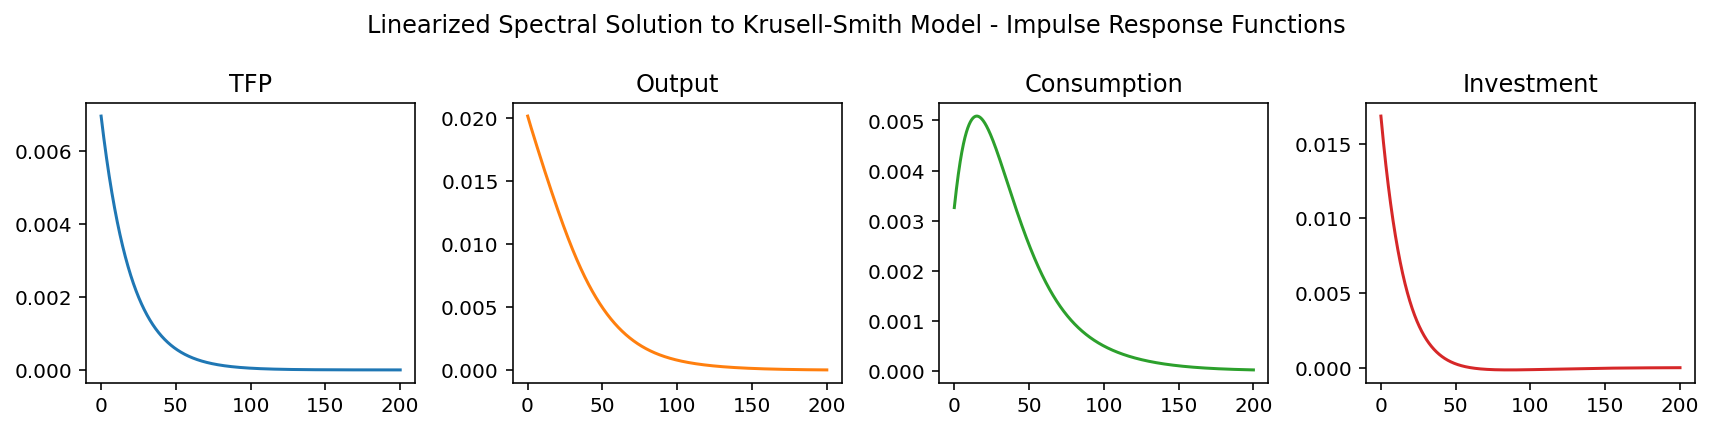

Saved to: krusell_smith_irf.pdf


In [16]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3), tight_layout=True)
ax = ax.flatten()

ax[0].plot(ts[1:], impulse_response_extended[4*N-1+0, 1:], 'C0')
#ax[0].plot(ts[1:], dt**0.5 * sigmaTFP * np.exp(-(1-rhoTFP)*ts[1:]), ls='--')
ax[0].set_title('TFP')
                  
ax[1].plot(ts[1:], impulse_response_extended[4*N-1+2, 1:], 'C1')
ax[1].set_title('Output')

ax[2].plot(ts[1:], impulse_response_extended[4*N-1+3, 1:], 'C2')
ax[2].set_title('Consumption')

ax[3].plot(ts[1:], impulse_response_extended[4*N-1+4, 1:], 'C3')
ax[3].set_title('Investment')

plt.suptitle('Linearized Spectral Solution to Krusell-Smith Model - Impulse Response Functions')
savefig(fig, 'krusell_smith_irf')

# Comparison with non-linear solution

In [17]:
tend_sim = 10000. # End of simulation
T_sim = 2000+1 # Number of periods

ts_sim = np.linspace(tstart, tend, T) # Periods
dt_sim = ts_sim[1]-ts_sim[0] # Difference between periods
print('tstart:', tstart, 'tend_sim:', tend_sim, 'T:', T_sim, 'dt:', dt_sim)

tstart: 0.0 tend_sim: 10000.0 T: 2001 dt: 0.1


In [18]:
# Pre-compile derivative matrix function
compute_M = jax.jit(jax.jacfwd(compute_dXt))

# Pre-compile non-linear capital function
@jax.jit
def compute_K(X):
    return compute_expectation(complete_gtrunc(X[2*N:4*N-1]), aa2, integrator)

# Draw shocks
np.random.seed(0)
shocks = np.random.normal(size=T_sim)

# List shock sizes and initialize errors
shock_std_devs = [0.0001, 0.001, 0.007, 0.01]
den_haan_errors = pd.Series(index=shock_std_devs)

In [19]:
for shock_std_dev in tqdm(shock_std_devs):
    
    simulation_linear = np.zeros((4*N, T_sim))
    simulation_nonlinear = np.zeros((4*N, T_sim))

    linear_implicit_update = np.linalg.inv(np.eye(4*N) - dt_sim * M_stab)

    for i in trange(T_sim-1):
        
        # Linear simulation
        simulation_linear[:, i+1] = linear_implicit_update @ (simulation_linear[:, i] + dt_sim**0.5 * psi_stab * shock_std_dev * shocks[i])

        # Non-linear simulation (linearized decision rules, non-linearly simulated distribution g)    
        simulation_nonlinear[:2*N, i+1] = simulation_linear[:2*N, i+1].copy()

        M_nonlinear = compute_M(X_steadystate+simulation_nonlinear[:, i])
        B_gZ_v = M_nonlinear[2*N:,:2*N]
        B_gZ_gZ = M_nonlinear[2*N:,2*N:]

        nonlinear_implicit_update = np.linalg.inv(np.eye(2*N) - dt_sim * (B_gZ_gZ + B_gZ_v@F)) # Use F from linearized solution
        
        simulation_nonlinear[2*N:, i+1] = nonlinear_implicit_update @ (simulation_nonlinear[2*N:, i] + dt_sim**0.5 * psi[2*N:] * shock_std_dev * shocks[i])

    K_linear = K + (extend_state[4*N-1+1] @ simulation_linear)
    K_nonlinear = np.array([compute_K(X_steadystate+simulation_nonlinear[:, i]) for i in trange(T_sim)])
    
    den_haan_errors.loc[shock_std_dev] = np.max(np.abs(np.log(K_linear)-np.log(K_nonlinear)))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

In [20]:
errors_table = pd.DataFrame([den_haan_errors.index, den_haan_errors]).T

errors_table[0] = (100*errors_table[0]).map('{:.2f}'.format)
errors_table[1] = (100*errors_table[1]).map('{:.3f}'.format)

errors_table.columns = ['Std. Dev. of TFP Shocks (\%)', 'Maximum Den Haan Error (\%)']

errors_table.to_latex('../tables/krusell_smith_den_haan_errors.tex', index=False, column_format='cc')

pprint(errors_table)

,Std. Dev. of TFP Shocks (\%),Maximum Den Haan Error (\%)
0,0.01,0.000
1,0.10,0.006
2,0.70,0.420
3,1.00,1.506


# Runtimes

In [21]:
from timeit import default_timer

In [22]:
runtimes = pd.DataFrame(columns=['start', 'Steady state', 'Derivatives', 'Linear system', 'Simulate IRF'], dtype=float)

for run in trange(100):
    
    start = default_timer()
    runtimes.loc[run, 'start'] = 0.

    ### Solve steady-state ###

    # Chebyshev nodes & differentiation matrix on [amin, amax]
    chebyshev = DiffMatOnDomain(xmin=amin, xmax=amax, dmat=Chebyshev(degree=N-1))
    a = chebyshev.nodes
    Da = chebyshev.at_order(1)

    # Size of finite volume cell at boundary constraint, could be anything but we pick a[1]-a[0]
    da = a[1]-a[0]

    # Repeated asset and tiled income arrays
    aa = np.tile(a, 2)
    zz = np.repeat(z, N)

    # Differentiation matrix w.r.t. a
    D_a = np.kron(np.eye(2), Da)

    # Switching matrix
    GG = np.kron(G,np.eye(N))

    # Initialize
    rmin = .0001 # Lower bound for steady state interest rate
    rmax = rho # Upper bound for steady state interest rate

    r = r0 # Initial guess for interest rate
    KD = (((alpha) / (r + delta)) ** (1 / (1 - alpha))) * zAvg # Initial guess for capital demand
    w = (1 - alpha) * KD**alpha * zAvg**-alpha # Initial guess for wages
    v = u_func(w*((1-tau)*zz+mu*(1-zz)) + r*aa)/rho # Initial guess for v

    Smin, Smax = np.nan, np.nan # Initialize excess savings

    for i_r in range(maxiter_r):

        KD = (((alpha) / (r + delta)) ** (1 / (1 - alpha))) * zAvg # Capital demand
        w = (1 - alpha) * KD**alpha * zAvg**-alpha # Wages

        # Solve HJB via iterative algorithm

        for i_hjb in range(maxiter_hjb):

            Delta = 0.01*np.exp(i_hjb)+1000*(i_r>0)

            dv = D_a@v
            c = du_inv(dv)
            s = w*((1-tau)*zz+mu*(1-zz)) + r*aa - c

            A = s.reshape(-1,1)*D_a + GG
            B = (1/Delta + rho)*np.eye(2*N) - A
            b = u_func(c) + v/Delta

            # Enforce lower asset constraint
            B[0] = D_a[0]
            b[0] = du_func(w*((1-tau)*zz[0]+mu*(1-zz[0])) + r*aa[0])

            # Enforce upper asset constraint if it binds
            if s[-1] >= 0:
                B[-1] = D_a[-1]
                b[-1] = du_func(w*((1-tau)*zz[-1]+mu*(1-zz[-1])) + r*aa[-1])

            v_old = v.copy()
            v = np.linalg.solve(B,b)

            if np.max(np.abs(v_old-v)) < crit_hjb: break

        # Solve KFE via spectral method with finite volume boundary cells

        try:
            amax2 = a[np.where(s[N:]>=0)[0][-1]+1] # Effective upper asset boundary where high-income savings turn negative
        except:
            amax2 = amax

        chebyshev_interior = DiffMatOnDomain(xmin=amin+da, xmax=amax2-da, dmat=Chebyshev(degree=N-1-2)) # Chebyshev nodes & differentiation matrix on [amin+da, amax-da]
        Da2_interior = chebyshev_interior.at_order(1)

        Da2_interior_pinv = np.linalg.pinv(Da2_interior) # Antiderivative matrix
        integrator = Da2_interior_pinv[-1] - Da2_interior_pinv[0] # Integral between boundaries amin+da, xmax=amax2-da

        a2 = np.hstack([amin, chebyshev_interior.nodes, amax2])
        aa2 = np.tile(a2, 2)

        Da2 = np.zeros((N,N))
        Da2[1:-1,1:-1] = Da2_interior
        D_a2 = np.kron(np.eye(2), Da2)

        interpolation_matrix = compute_interpolation_matrix(a, a2)

        s2 = np.hstack([interpolation_matrix @ s[:N], interpolation_matrix @ s[N:]])

        C = -D_a2*s2 + GG.T

        C[0,0], C[0,1], C[0,N] = -lambda1, -s[1]/da, lambda2 # Net flows for low-income @ bottom constraint
        C[N,0], C[N,N] = lambda1, -lambda2-s[N]/da # Net flows for high-income @ bottom constraint
        C[N+1,:], C[N+1,N], C[N+1,N+1], C[N+1,1] = 0, s[N]/da, -lambda2-s[N+1]/da, lambda1 # Net flows for high-income just above bottom constraint

        C[-1,-1], C[-1,-2], C[-1,-(N+1)] = -lambda2+s[-1]/da, s[-2]/da, lambda1 # Net flows for high-income @ top constraint
        C[-(N+1),-1], C[-(N+1),-(N+1)] = lambda2, -lambda1+s[-(N+1)]/da # Net flows for low-income @ top constraint
        C[-(N+2),:], C[-(N+2),-(N+1)], C[-(N+2),-(N+2)], C[-(N+2),-2] = 0, -s[-(N+1)]/da, -lambda1+s[-(N+2)]/da, lambda2 # Net flows for low-income just below top constraint

        # Compute & normalize zero eigenvector
        l, g = sparse.linalg.eigs(C, sigma=0, k=1)
        g = np.real_if_close(g).flatten()
        g /= compute_expectation(g, np.ones_like(g), integrator)

        # Compute capital
        KS = compute_expectation(g, aa2, integrator)
        S = KS-KD

        if S>crit_S:
            rmax, Smax = r, S
        elif S<-crit_S:
            rmin, Smin = r, S
        else:
            break

        if np.isnan(Smin) or np.isnan(Smax):
            r = (rmin+rmax)/2 # Dichotomy
        else:
            r = (Smax * rmin - Smin * rmax) / (Smax - Smin) # Secant

    K = KS # Steady-state capital, exactly consistent with g
    r = alpha * K**(alpha-1) * zAvg**(1-alpha) - delta # Steady-state interest rate
    w = (1 - alpha) * KS**alpha * zAvg**-alpha # Steady-state wages
    
    runtimes.loc[run, 'Steady state'] = default_timer() - start

    ### Compute derivatives ###

    gtrunc = g[:-1]

    # This approach is slightly faster than the one above, but also slightly less elegant
    def compute_dXt_KYCI(X):
    
        # Unpack vector X
        v = X[:2*N]
        gtrunc = X[2*N:4*N-1]
        Z = X[-1]

        # Complete distribution
        g = complete_gtrunc(gtrunc)

        # Compute macro aggregates
        K = compute_expectation(g, aa2, integrator) # Capital
        Y = jnp.exp(Z) * (K ** alpha) * (zAvg ** (1 - alpha)) # Output
        r = jnp.exp(Z) * alpha * K**(alpha-1) * zAvg**(1-alpha) - delta # Interest rate
        w = jnp.exp(Z) * (1 - alpha) * KS**alpha * zAvg**-alpha # Wages

        # Compute decision rules 
        dv = D_a@v
        c = du_inv(dv)
        s = w*((1-tau)*zz+mu*(1-zz)) + r*aa - c

        # Evolution of value function (with credit constraint)
        A = s.reshape(-1,1)*D_a + GG
        dvt = u_func(c) + A @ v - rho*v

        # Evolution of distribution

        s2 = jnp.hstack([interpolation_matrix @ s[:N], interpolation_matrix @ s[N:]])

        C = -D_a2*s2 + GG.T

        C = C.at[0, 1].add(-s[1] / da)
    
        C = C.at[N, N].add(- s[N] / da)

        C = C.at[N + 1, :].set(0)
        C = C.at[N + 1, N].set(s[N] / da)
        C = C.at[N + 1, N + 1].set(-lambda2-s[N+1] / da)
        C = C.at[N + 1, 1].set(lambda1)

        C = C.at[-1, -1].add(s[-1] / da)
        C = C.at[-1, -2].add(s[-2] / da)

        C = C.at[-(N + 1), -(N + 1)].add(s[-(N + 1)] / da)

        C = C.at[-(N + 2), :].set(0)
        C = C.at[-(N + 2), -(N + 1)].set(-s[-(N + 1)] / da)
        C = C.at[-(N + 2), -(N + 2)].set(-lambda1+s[-(N + 2)] / da)
        C = C.at[-(N + 2), -2].set(lambda2)

        dgt = (C @ g)[:-1]
        
        # Evolution of TFP Z

        dZt = -(1-rhoTFP)*Z

        # Compute consumption

        c2 = jnp.hstack([interpolation_matrix @ c[:N], interpolation_matrix @ c[N:]])
        C = compute_expectation(g, c2, integrator)

        # Compute investment

        I = compute_expectation(g, s2, integrator) + delta*K

        return jnp.hstack([-dvt, dgt, dZt, K, Y, C, I])

    M_full = jax.jacfwd(compute_dXt_KYCI)(X_steadystate)

    M = M_full[:4*N,:]

    M_KYCI = M_full[4*N:,:]
    extend_state = np.vstack([np.eye(4*N), M_KYCI])
    
    runtimes.loc[run, 'Derivatives'] = default_timer() - start

    ### Solve linear system ###

    M_stab, psi_stab, F, existence, uniqueness = schur_solver(M, psi_stab, n_state_vars=2*N, verbose=False)
    
    runtimes.loc[run, 'Linear system'] = default_timer() - start

    ### Simulate IRF ###

    shocks = np.zeros(T)
    shocks[0] = 1.

    simulation = np.zeros((4*N, T))

    implicit_update = np.linalg.inv(np.eye(4*N) - M_stab * dt)

    for i in range(T-1):
        simulation[:, i+1] = implicit_update @ (simulation[:, i] + dt**0.5 * psi_stab * shocks[i])

    simulation_extended = extend_state @ simulation
    
    runtimes.loc[run, 'Simulate IRF'] = default_timer() - start

  0%|          | 0/100 [00:00<?, ?it/s]

In [23]:
runtimes_table = runtimes.mean().diff().dropna()

runtimes_table[r'\textbf{Total}'] = runtimes_table.sum()

runtimes_table = runtimes_table.map('{:.3f}'.format).astype(str) + 's'

runtimes_table.name = 'Runtime'

runtimes_table.to_latex('../tables/krusell_smith_runtimes.tex', column_format='lc')

pprint(runtimes_table)

,Runtime
Steady state,0.047s
Derivatives,0.230s
Linear system,0.011s
Simulate IRF,0.034s
\textbf{Total},0.322s


In [24]:
%%timeit -r 1000 -n 1
compute_M(X_steadystate)

The slowest run took 26.13 times longer than the fastest. This could mean that an intermediate result is being cached.
1.39 ms ± 1.19 ms per loop (mean ± std. dev. of 1000 runs, 1 loop each)
